In [1]:
import os
#import modal
    
LOCAL=True

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/194711
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.

Finished: Reading data from Hopsworks, using Hive (2.10s) 
Flower predicted: Versicolor


Uploading: 100.000%|█████████████████████████████████████████████████████████████████████████| 146443/146443 elapsed<00:04 remaining<00:00


Finished: Reading data from Hopsworks, using Hive (2.74s) 
Flower actual: Versicolor


Uploading: 100.000%|█████████████████████████████████████████████████████████████████████████| 146443/146443 elapsed<00:02 remaining<00:00
Uploading Dataframe: 100.00% |████████████████████████████████████████████████████| Rows 1/1 | Elapsed Time: 00:09 | Remaining Time: 00:00


Launching job: iris_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/194711/jobs/named/iris_predictions_1_offline_fg_materialization/executions


Finished: Reading data from Hopsworks, using Hive (2.39s) 


Uploading: 100.000%|███████████████████████████████████████████████████████████████████████████| 26054/26054 elapsed<00:01 remaining<00:00


Number of different flower predictions to date: 3


Uploading: 100.000%|███████████████████████████████████████████████████████████████████████████| 17362/17362 elapsed<00:01 remaining<00:00


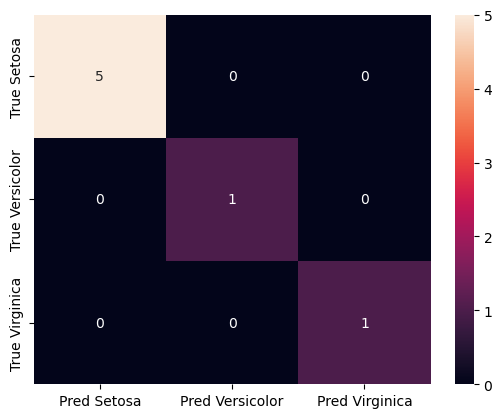

In [7]:
if LOCAL == False:
   stub = modal.Stub()
   hopsworks_image = modal.Image.debian_slim().pip_install(["hopsworks","joblib","seaborn","sklearn==1.1.1","dataframe-image"])
   @stub.function(image=hopsworks_image, schedule=modal.Period(days=1), secret=modal.Secret.from_name("HOPSWORKS_API_KEY"))
   def f():
       g()

def g():
    import pandas as pd
    import hopsworks
    import joblib
    import datetime
    from PIL import Image
    from datetime import datetime
    import dataframe_image as dfi
    from sklearn.metrics import confusion_matrix
    from matplotlib import pyplot
    import seaborn as sns
    import requests

    project = hopsworks.login()
    fs = project.get_feature_store()
    
    mr = project.get_model_registry()
    model = mr.get_model("iris_model", version=1)
    model_dir = model.download()
    model = joblib.load(model_dir + "/iris_model.pkl")
    
    feature_view = fs.get_feature_view(name="iris", version=1)
    batch_data = feature_view.get_batch_data()
    
    y_pred = model.predict(batch_data)
    #print(y_pred)
    offset = 1
    flower = y_pred[y_pred.size-offset]
    flower_url = "https://raw.githubusercontent.com/featurestoreorg/serverless-ml-course/main/src/01-module/assets/" + flower + ".png"
    print("Flower predicted: " + flower)
    img = Image.open(requests.get(flower_url, stream=True).raw)            
    img.save("./latest_iris.png")
    dataset_api = project.get_dataset_api()    
    dataset_api.upload("./latest_iris.png", "Resources/images", overwrite=True)
   
    iris_fg = fs.get_feature_group(name="iris", version=1)
    df = iris_fg.read() 
    #print(df)
    label = df.iloc[-offset]["variety"]
    label_url = "https://raw.githubusercontent.com/featurestoreorg/serverless-ml-course/main/src/01-module/assets/" + label + ".png"
    print("Flower actual: " + label)
    img = Image.open(requests.get(label_url, stream=True).raw)            
    img.save("./actual_iris.png")
    dataset_api.upload("./actual_iris.png", "Resources/images", overwrite=True)
    
    monitor_fg = fs.get_or_create_feature_group(name="iris_predictions",
                                                version=1,
                                                primary_key=["datetime"],
                                                description="Iris flower Prediction/Outcome Monitoring"
                                                )
    
    now = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
    data = {
        'prediction': [flower],
        'label': [label],
        'datetime': [now],
       }
    monitor_df = pd.DataFrame(data)
    monitor_fg.insert(monitor_df, write_options={"wait_for_job" : False})
    
    history_df = monitor_fg.read()
    # Add our prediction to the history, as the history_df won't have it - 
    # the insertion was done asynchronously, so it will take ~1 min to land on App
    history_df = pd.concat([history_df, monitor_df])


    df_recent = history_df.tail(4)
    dfi.export(df_recent, './df_recent.png', table_conversion = 'matplotlib')
    dataset_api.upload("./df_recent.png", "Resources/images", overwrite=True)
    
    predictions = history_df[['prediction']]
    labels = history_df[['label']]

    # Only create the confusion matrix when our iris_predictions feature group has examples of all 3 iris flowers
    print("Number of different flower predictions to date: " + str(predictions.value_counts().count()))
    if predictions.value_counts().count() == 3:
        results = confusion_matrix(labels, predictions)
    
        df_cm = pd.DataFrame(results, ['True Setosa', 'True Versicolor', 'True Virginica'],
                             ['Pred Setosa', 'Pred Versicolor', 'Pred Virginica'])
    
        cm = sns.heatmap(df_cm, annot=True)
        fig = cm.get_figure()
        fig.savefig("./confusion_matrix.png")
        dataset_api.upload("./confusion_matrix.png", "Resources/images", overwrite=True)
    else:
        print("You need 3 different flower predictions to create the confusion matrix.")
        print("Run the batch inference pipeline more times until you get 3 different iris flower predictions") 


if __name__ == "__main__":
    if LOCAL == True :
        g()
    else:
        with stub.run():
            f()

